# Code to analyze method of using pre-defined battery charging schedule
Not used in actual report

In [1]:
#import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter

# Data pre-processing

In [2]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('../data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [3]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sore by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].dt.year
demand_unpivoted['month'] = demand_unpivoted['Date'].dt.month
demand_unpivoted['weekday'] = demand_unpivoted['Date'].dt.weekday
demand_unpivoted = demand_unpivoted.fillna(0)
demand_unpivoted.head() 

,Date,period,demand,year,month,weekday
0,2018-01-01,Period01 [kWh],734.40,2018,1,0
1,2018-01-01,Period02 [kWh],731.52,2018,1,0
2,2018-01-01,Period03 [kWh],727.20,2018,1,0
3,2018-01-01,Period04 [kWh],735.84,2018,1,0
4,2018-01-01,Period05 [kWh],730.08,2018,1,0


# Pre-defined schedule of battery based on peak demand charge ratchets

In [4]:
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
forecast = pd.read_csv('../data/forecasted_demand.csv', parse_dates=['interval'], date_parser=date_parser, index_col='Unnamed: 0') 
forecast_2019 = forecast[forecast['interval'] >= datetime(2019, 1, 1)].reset_index(drop=True)
forecast_2019['month'] = forecast_2019['interval'].apply(lambda x: x.month)
forecast_2019.head()

,interval,data,forecast,month
0,2019-01-01 00:00:00,666.72,686.802478,1
1,2019-01-01 00:15:00,665.28,687.262579,1
2,2019-01-01 00:30:00,679.68,691.316724,1
3,2019-01-01 00:45:00,676.80,690.248117,1
4,2019-01-01 01:00:00,681.12,686.298023,1


In [5]:
#say we have a 350 power rated battery (4200 energy rating). charge up fully during non-expensive periods
#For first instance we'll need to use 8 hours to charge (12am-8am)
battery_e = 250*12
cost_battery = 250*12*50 + 250*500
print(f'charge battery to full capacity (100% efficiency) {battery_e/8/4} MW per period from 12am-8am')
#Remember the eta is actually different:
charge_per_period_1 = battery_e/.7/8/4
charge_per_period_rest = battery_e/.7/10/4
print(f'charge battery to full capacity (70% efficiency) {charge_per_period_1} MW per period from 12am-8am and {charge_per_period_rest} from 10pm-8am')
#Check what the discharge is per period
discharge_per_period_no_loss = battery_e/14/4
discharge_per_period = discharge_per_period_no_loss*.7
print(f'discharge full charged battery (70% efficiency) {discharge_per_period} MW per period from 8am-10pm')
print(f'Save {discharge_per_period*4} in peak demand which is ${discharge_per_period*4*18.71} in winter and ${discharge_per_period*4*(9.15 + 18.44 + 16.66)} in summer')
print(f'save {discharge_per_period*4*18.71*8 + discharge_per_period*4*(9.15 + 18.44 + 16.66)*4} annually, or {10*(discharge_per_period*4*18.71*8 + discharge_per_period*4*(9.15 + 18.44 + 16.66)*4)} over 10 years')
print(f'battery cost is {battery_e/12*500+50*battery_e}')

charge battery to full capacity (100% efficiency) 93.75 MW per period from 12am-8am
charge battery to full capacity (70% efficiency) 133.92857142857144 MW per period from 12am-8am and 107.14285714285715 from 10pm-8am
discharge full charged battery (70% efficiency) 37.49999999999999 MW per period from 8am-10pm
Save 149.99999999999997 in peak demand which is $2806.4999999999995 in winter and $6637.499999999999 in summer
save 49001.99999999999 annually, or 490019.99999999994 over 10 years
battery cost is 275000.0


In [6]:
#Charge on a ratchet scale - for first day of the battery, charge in 8 hours, for rest, charge over 10 hours
charge_jan_1_2019_12am_8am = np.tile(np.array([charge_per_period_1]),8*4)
charge_jan_2019_8am_10pm = np.tile(np.array([0]),14*4)
charge_jan_2019_10pm_12am = np.tile(np.array([charge_per_period_rest]),2*4)
charge_jan_1_2019 = np.append(charge_jan_1_2019_12am_8am, np.append(charge_jan_2019_8am_10pm, charge_jan_2019_10pm_12am))
#Can create the charge for the rest of the days using charge_per_period_rest
charge_jan_other_2019_12am_8am = np.tile(np.array([charge_per_period_rest]),8*4)
charge_jan_other_2019 = np.append(charge_jan_other_2019_12am_8am, np.append(charge_jan_2019_8am_10pm, charge_jan_2019_10pm_12am))
charge_2019 = np.append(charge_jan_1_2019, np.tile(charge_jan_other_2019, 364))
sum(charge_jan_other_2019*.7)

3000.0

In [7]:
#Disharge from 8am-10pm every day
discharge_jan_2019_12am_8am = np.tile(np.array([0]),8*4)
discharge_jan_2019_8am_10pm = np.tile(np.array([discharge_per_period]),14*4)  
discharge_jan_2019_10pm_12am = np.tile(np.array([0]),2*4)
discharge_jan_2019 = np.append(discharge_jan_2019_12am_8am, np.append(discharge_jan_2019_8am_10pm, discharge_jan_2019_10pm_12am))
jan_2019_discharge = np.tile(discharge_jan_2019,31)
discharge_2019 = np.tile(discharge_jan_2019,  365)
sum(discharge_jan_2019/.7)

2999.9999999999995

In [8]:
forecast_2019['charge'] = charge_2019
forecast_2019['discharge'] = discharge_2019
forecast_2019['demand_plus_charge'] = forecast_2019['data'] + forecast_2019['charge']
forecast_2019['demand_minus_discharge'] = forecast_2019['data'] - forecast_2019['discharge']
forecast_2019['demand_plus_charge_minus_discharge'] = forecast_2019['data'] - forecast_2019['discharge']+ forecast_2019['charge']
# Add column for rolling sum of current row and preious for demand\n",
forecast_2019['rolling_demand'] = forecast_2019[['data']].rolling(2).sum()
forecast_2019['rolling_demand_plus_charge'] = forecast_2019[['demand_plus_charge']].rolling(2).sum()
forecast_2019['rolling_demand_minus_discharge'] = forecast_2019[['demand_minus_discharge']].rolling(2).sum()
forecast_2019['rolling_demand_plus_charge_minus_discharge'] = forecast_2019[['demand_plus_charge_minus_discharge']].rolling(2).sum()
forecast_2019.head()

,interval,data,forecast,month,charge,discharge,demand_plus_charge,demand_minus_discharge,demand_plus_charge_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge,rolling_demand_plus_charge_minus_discharge
0,2019-01-01 00:00:00,666.72,686.802478,1,133.928571,0.0,800.648571,666.72,800.648571,NaN,NaN,NaN,NaN
1,2019-01-01 00:15:00,665.28,687.262579,1,133.928571,0.0,799.208571,665.28,799.208571,1332.00,1599.857143,1332.00,1599.857143
2,2019-01-01 00:30:00,679.68,691.316724,1,133.928571,0.0,813.608571,679.68,813.608571,1344.96,1612.817143,1344.96,1612.817143
3,2019-01-01 00:45:00,676.80,690.248117,1,133.928571,0.0,810.728571,676.80,810.728571,1356.48,1624.337143,1356.48,1624.337143
4,2019-01-01 01:00:00,681.12,686.298023,1,133.928571,0.0,815.048571,681.12,815.048571,1357.92,1625.777143,1357.92,1625.777143


In [9]:
#Find peak location with battery and without
peak_loc_battery = pd.DataFrame(forecast_2019['month'].unique(), forecast_2019.loc[forecast_2019.groupby('month')['rolling_demand_plus_charge_minus_discharge'].idxmax(),'interval']).reset_index()
peak_loc_battery.columns = ['peak_loc_battery', 'month']
peak_loc_baseline = pd.DataFrame(forecast_2019['month'].unique(), forecast_2019.loc[forecast_2019.groupby('month')['rolling_demand'].idxmax(),'interval']).reset_index()
peak_loc_baseline.columns = ['peak_loc_baseline', 'month']
# peak_loc_baseline['interval'][0] < datetime(2019,1,24, 13,46,0)
peak_loc_battery

,peak_loc_battery,month
0,2019-01-24 13:45:00,1
1,2019-02-15 07:45:00,2
2,2019-03-12 07:30:00,3
3,2019-04-19 14:45:00,4
4,2019-05-20 07:30:00,5
5,2019-06-25 23:00:00,6
6,2019-07-20 07:30:00,7
7,2019-08-19 16:30:00,8
8,2019-09-12 07:45:00,9
9,2019-10-02 13:45:00,10


In [10]:
scheduled_results = pd.DataFrame(forecast_2019.groupby('month').agg(
    {'demand_plus_charge_minus_discharge':'sum',
    'rolling_demand_plus_charge_minus_discharge': 'max',
    'data':'sum',
    'rolling_demand':'max'})).reset_index()
scheduled_results.columns = ['month', 'demand_w_battery', 'p_battery','demand','p']
scheduled_results = scheduled_results.merge(peak_loc_battery,how='left', on='month')
scheduled_results = scheduled_results.merge(peak_loc_baseline,how='left', on='month')
scheduled_results['peak_time_battery'] = scheduled_results['peak_loc_battery'].apply(lambda x: x.time())
scheduled_results['B_battery'] = np.where(scheduled_results['month'].isin([6,7,8,9]), np.where(
    #summer - Time before 8am
    scheduled_results['peak_time_battery']< time(8,0,0), 16.66, np.where(
        #summer - Time 8am-6pm
        scheduled_results['peak_time_battery'] < time(18,0,0), 16.66+18.44+9.15, np.where(
            #summer - time 6pm-10pm
            scheduled_results['peak_time_battery'] < time(22,0,0), 16.66 + 18.44, 16.66))), np.where(
                #Time before 8am
                scheduled_results['peak_time_battery']< time(8,0,0), 4.21, np.where(
                    #Time 8am-10pm
                    scheduled_results['peak_time_battery'] < time(22,0,0), 4.21+13.96, 4.21)))
scheduled_results['peak_time_baseline'] = scheduled_results['peak_loc_baseline'].apply(lambda x: x.time())
scheduled_results['B_baseline'] = np.where(scheduled_results['month'].isin([6,7,8,9]), np.where(
    #summer - Time before 8am
    scheduled_results['peak_time_baseline']< time(8,0,0), 16.66, np.where(
        #summer - Time 8am-6pm
        scheduled_results['peak_time_baseline'] < time(18,0,0), 16.66+18.44+9.15, np.where(
            #summer - time 6pm-10pm
            scheduled_results['peak_time_baseline'] < time(22,0,0), 16.66 + 18.44, 16.66))), np.where(
                #Time before 8am
                scheduled_results['peak_time_baseline']< time(8,0,0), 4.21, np.where(
                    #Time 8am-10pm
                    scheduled_results['peak_time_baseline'] < time(22,0,0), 4.21+13.96, 4.21)))
scheduled_results

,month,demand_w_battery,p_battery,demand,p,peak_loc_battery,peak_loc_baseline,peak_time_battery,B_battery,peak_time_baseline,B_baseline
0,1,2.166568e+06,1781.160000,2097953.28,1856.16,2019-01-24 13:45:00,2019-01-24 13:45:00,13:45:00,18.17,13:45:00,18.17
1,2,1.975553e+06,1838.605714,1914353.28,1709.28,2019-02-15 07:45:00,2019-02-05 11:00:00,07:45:00,4.21,11:00:00,18.17
2,3,2.228081e+06,1772.365714,2160324.00,1836.00,2019-03-12 07:30:00,2019-03-15 15:45:00,07:30:00,4.21,15:45:00,18.17
3,4,2.225895e+06,1933.800000,2160324.00,2008.80,2019-04-19 14:45:00,2019-04-19 14:45:00,14:45:00,18.17,14:45:00,18.17
4,5,2.422792e+06,2125.165714,2355035.04,2112.48,2019-05-20 07:30:00,2019-05-20 11:30:00,07:30:00,4.21,11:30:00,18.17
5,6,2.637433e+06,2372.845714,2571861.60,2384.64,2019-06-25 23:00:00,2019-06-25 15:00:00,23:00:00,16.66,15:00:00,44.25
6,7,3.093487e+06,2708.365714,3025729.44,2698.56,2019-07-20 07:30:00,2019-07-19 16:30:00,07:30:00,16.66,16:30:00,44.25
7,8,2.889839e+06,2521.320000,2822081.76,2596.32,2019-08-19 16:30:00,2019-08-19 16:30:00,16:30:00,44.25,16:30:00,44.25
8,9,2.570146e+06,2293.645714,2504574.72,2295.36,2019-09-12 07:45:00,2019-09-11 17:00:00,07:45:00,16.66,17:00:00,44.25
9,10,2.450568e+06,2295.240000,2382811.20,2370.24,2019-10-02 13:45:00,2019-10-02 13:45:00,13:45:00,18.17,13:45:00,18.17


In [11]:
scheduled_results['op_costs_battery'] = scheduled_results['B_battery']*scheduled_results['p_battery']*2 + .13*scheduled_results['demand_w_battery']
scheduled_results['op_costs_baseline'] = scheduled_results['B_baseline']*scheduled_results['p']*2 + .13*scheduled_results['demand']
scheduled_results['saved_cost'] = scheduled_results['op_costs_baseline'] - scheduled_results['op_costs_battery']
scheduled_results

,month,demand_w_battery,p_battery,demand,p,peak_loc_battery,peak_loc_baseline,peak_time_battery,B_battery,peak_time_baseline,B_baseline,op_costs_battery,op_costs_baseline,saved_cost
0,1,2.166568e+06,1781.160000,2097953.28,1856.16,2019-01-24 13:45:00,2019-01-24 13:45:00,13:45:00,18.17,13:45:00,18.17,346381.137943,340186.7808,-6194.357143
1,2,1.975553e+06,1838.605714,1914353.28,1709.28,2019-02-15 07:45:00,2019-02-05 11:00:00,07:45:00,4.21,11:00:00,18.17,272302.986514,310981.1616,38678.175086
2,3,2.228081e+06,1772.365714,2160324.00,1836.00,2019-03-12 07:30:00,2019-03-15 15:45:00,07:30:00,4.21,15:45:00,18.17,304573.867886,347562.3600,42988.492114
3,4,2.225895e+06,1933.800000,2160324.00,2008.80,2019-04-19 14:45:00,2019-04-19 14:45:00,14:45:00,18.17,14:45:00,18.17,359640.697714,353841.9120,-5798.785714
4,5,2.422792e+06,2125.165714,2355035.04,2112.48,2019-05-20 07:30:00,2019-05-20 11:30:00,07:30:00,4.21,11:30:00,18.17,332856.879086,382922.0784,50065.199314
5,6,2.637433e+06,2372.845714,2571861.60,2384.64,2019-06-25 23:00:00,2019-06-25 15:00:00,23:00:00,16.66,15:00:00,44.25,421929.512914,545382.6480,123453.135086
6,7,3.093487e+06,2708.365714,3025729.44,2698.56,2019-07-20 07:30:00,2019-07-19 16:30:00,07:30:00,16.66,16:30:00,44.25,492396.001371,632167.3872,139771.385829
7,8,2.889839e+06,2521.320000,2822081.76,2596.32,2019-08-19 16:30:00,2019-08-19 16:30:00,16:30:00,44.25,16:30:00,44.25,598815.877371,596644.9488,-2170.928571
8,9,2.570146e+06,2293.645714,2504574.72,2295.36,2019-09-12 07:45:00,2019-09-11 17:00:00,07:45:00,16.66,17:00:00,44.25,410543.274514,528734.0736,118190.799086
9,10,2.450568e+06,2295.240000,2382811.20,2370.24,2019-10-02 13:45:00,2019-10-02 13:45:00,13:45:00,18.17,13:45:00,18.17,401982.906171,395899.9776,-6082.928571


In [12]:
sum(scheduled_results['saved_cost']) - cost_battery

257375.86411428568

In [13]:
aug_2019 = forecast_2019[forecast_2019['month'] == 1].reset_index()
orig_peak_loc = aug_2019.loc[aug_2019['rolling_demand'].argmax()]['interval']
new_peak_loc = aug_2019.loc[aug_2019['rolling_demand_plus_charge_minus_discharge'].argmax()]['interval']
if  new_peak_loc== orig_peak_loc:
    print('battery did not change the location of the peak demand periods')
else:
    print(f'battery did change peak location from {orig_peak_loc} to {new_peak_loc}')

battery did not change the location of the peak demand periods


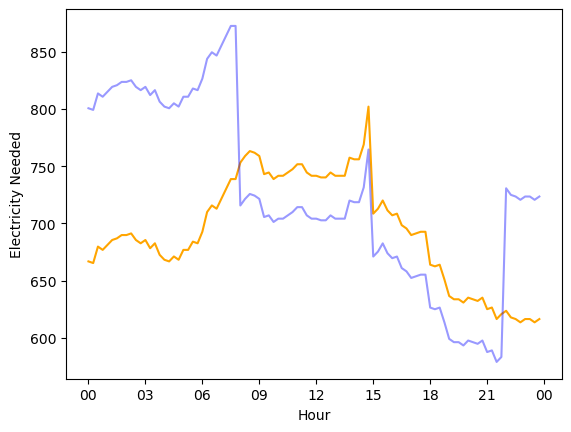

In [14]:
start_idx = 0
end_idx = 96
_ = plt.plot(forecast_2019['interval'][start_idx:end_idx], forecast_2019['data'][start_idx:end_idx], color='orange')
_ = plt.plot(forecast_2019['interval'][start_idx:end_idx], forecast_2019['demand_plus_charge_minus_discharge'][start_idx:end_idx], alpha=.4, color='blue')
_ = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
_ = plt.xlabel('Hour')
_ = plt.ylabel('Electricity Needed')
# _ = plt.xticks(rotations=45)

In [ ]:
#need to incorporate something about how to account for differences in forecasted vs. actual demand?
#Maybe not because we are shaving the demand no matter what
#Would this increase in charge change the demand in the non-expensive periods to be more than peak - confirm that charging doesn't change the peak


In [ ]:
jan_2019_summary = pd.DataFrame(columns=['timestamp', 'demand','charge', 'discharge', 'demand_plus_charge'])
jan_2019_summary['timestamp'] = forecast_2019[forecast_2019['month'] == 1]['interval']
jan_2019_summary['demand'] = forecast_2019[forecast_2019['month'] == 1]['data']
jan_2019_summary['charge'] = jan_2019_charge
jan_2019_summary['discharge'] = jan_2019_discharge
jan_2019_summary['demand_plus_charge'] = jan_2019_summary['demand'] + jan_2019_summary['charge']
jan_2019_summary['demand_minus_discharge'] = jan_2019_summary['demand'] - jan_2019_summary['discharge']
# Add column for rolling sum of current row and preious for demand\n",
jan_2019_summary['rolling_demand'] = jan_2019_summary[['demand']].rolling(2).sum()
jan_2019_summary['rolling_demand_plus_charge'] = jan_2019_summary[['demand_plus_charge']].rolling(2).sum()
jan_2019_summary['rolling_demand_minus_discharge'] = jan_2019_summary[['demand_minus_discharge']].rolling(2).sum()
jan_2019_summary.head()


,timestamp,demand,charge,discharge,demand_plus_charge,demand_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge
0,2019-01-01 00:00:00,666.72,133.928571,0.0,800.648571,666.72,NaN,NaN,NaN
1,2019-01-01 00:15:00,665.28,133.928571,0.0,799.208571,665.28,1332.00,1599.857143,1332.00
2,2019-01-01 00:30:00,679.68,133.928571,0.0,813.608571,679.68,1344.96,1612.817143,1344.96
3,2019-01-01 00:45:00,676.80,133.928571,0.0,810.728571,676.80,1356.48,1624.337143,1356.48
4,2019-01-01 01:00:00,681.12,133.928571,0.0,815.048571,681.12,1357.92,1625.777143,1357.92


In [ ]:
if jan_2019_summary.loc[jan_2019_summary['rolling_demand_plus_charge'].argmax()]['timestamp'] == jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()]['timestamp']:
    print('charging did not change the peak demand periods')

charging did not change the peak demand periods


In [ ]:
if jan_2019_summary.loc[jan_2019_summary['rolling_demand_minus_discharge'].argmax()]['timestamp'] == jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()]['timestamp']:
    print('discharging did not change the peak demand periods')

discharging did not change the peak demand periods


In [ ]:
jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()-1:jan_2019_summary['rolling_demand'].argmax()]

,timestamp,demand,charge,discharge,demand_plus_charge,demand_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge
2262,2019-01-24 13:30:00,931.68,0.0,37.5,931.68,894.18,1854.72,1854.72,1779.72
2263,2019-01-24 13:45:00,924.48,0.0,37.5,924.48,886.98,1856.16,1856.16,1781.16


In [ ]:
print(f'monthly cost of inefficiency {(battery_e/.7-battery_e)*31*.13}')

monthly cost of inefficiency 5181.428571428573
